# Baseline Model using Opcode Freq

## Set up

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import json
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


In [3]:
PATH = Path.cwd().parents[2]
DATA_PATH = os.path.join(PATH, 'data/processed/ir_gigahorse')

## List Traditional ML model to compare

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier

models = {
  # MultiOutputClassifier Wrappers
  "MultiOutputClassifier(LogisticRegression())": MultiOutputClassifier(LogisticRegression()),
  "MultiOutputClassifier(DecisionTreeClassifier())": MultiOutputClassifier(DecisionTreeClassifier()),
  "MultiOutputClassifier(RandomForestClassifier())": MultiOutputClassifier(RandomForestClassifier()),
  "MultiOutputClassifier(AdaBoostClassifier())": MultiOutputClassifier(AdaBoostClassifier()),
  "MultiOutputClassifier(ExtraTreesClassifier())": MultiOutputClassifier(ExtraTreesClassifier()),
  "MultiOutputClassifier(XGBClassifier())": MultiOutputClassifier(XGBClassifier()),
  "MultiOutputClassifier(LGBMClassifier())": MultiOutputClassifier(LGBMClassifier()),
  "MultiOutputClassifier(SVC())": MultiOutputClassifier(SVC()),
  "MultiOutputClassifier(GaussianNB())": MultiOutputClassifier(GaussianNB()),
  "MultiOutputClassifier(KNeighborsClassifier())": MultiOutputClassifier(KNeighborsClassifier()),
  "MultiOutputClassifier(SGDClassifier())": MultiOutputClassifier(SGDClassifier()),
  "MultiOutputClassifier(MLPClassifier())": MultiOutputClassifier(MLPClassifier()),

  # OneVsRestClassifier Wrappers
  "OneVsRestClassifier(LogisticRegression())": OneVsRestClassifier(LogisticRegression()),
  "OneVsRestClassifier(DecisionTreeClassifier())": OneVsRestClassifier(DecisionTreeClassifier()),
  "OneVsRestClassifier(RandomForestClassifier())": OneVsRestClassifier(RandomForestClassifier()),
  "OneVsRestClassifier(AdaBoostClassifier())": OneVsRestClassifier(AdaBoostClassifier()),
  "OneVsRestClassifier(ExtraTreesClassifier())": OneVsRestClassifier(ExtraTreesClassifier()),
  "OneVsRestClassifier(XGBClassifier())": OneVsRestClassifier(XGBClassifier()),
  "OneVsRestClassifier(LGBMClassifier())": OneVsRestClassifier(LGBMClassifier()),
  "OneVsRestClassifier(SVC())": OneVsRestClassifier(SVC()),
  "OneVsRestClassifier(GaussianNB())": OneVsRestClassifier(GaussianNB()),
  "OneVsRestClassifier(KNeighborsClassifier())": OneVsRestClassifier(KNeighborsClassifier()),
  "OneVsRestClassifier(SGDClassifier())": OneVsRestClassifier(SGDClassifier()),
  "OneVsRestClassifier(MLPClassifier())": OneVsRestClassifier(MLPClassifier()),
}

## Load Dataset

In [5]:
df = pd.read_csv(os.path.join(DATA_PATH, 'opcode_freq_dataset.csv')).set_index('address')
grouping_df = pd.read_csv(os.path.join(DATA_PATH, 'grouping_opcode_freq_dataset.csv')).set_index('address')

with open(os.path.join(DATA_PATH, 'features.json'), "r") as f:
    features = json.load(f)

with open(os.path.join(DATA_PATH, 'grouping_features.json'), "r") as f:
    grouping_features = json.load(f)

with open(os.path.join(DATA_PATH, 'labels.json'), "r") as f:
    labels = json.load(f)

In [6]:
df.head()

,mint,leak,limit,PUSH1,MSTORE,CALLVALUE,DUP1,ISZERO,PUSH2,JUMPI,REVERT,JUMPDEST,POP,CALLDATASIZE,LT,CALLDATALOAD,SHR,PUSH4,GT,EQ,JUMP,MLOAD,DUP3,DUP4,DUP2,ADD,SWAP2,SWAP3,SWAP1,DUP6,AND,SUB,EXP,NOT,RETURN,SHL,SLOAD,DUP9,MUL,SWAP6,...,SELFBALANCE,SWAP14,ADDMOD,SGT,PUSH9,SAR,SWAP10,BALANCE,SDIV,CALLDATACOPY,SWAP9,SWAP8,PUSH26,CODESIZE,SELFDESTRUCT,BLOCKHASH,MSTORE8,DIFFICULTY,COINBASE,EXTCODEHASH,BASEFEE,PUSH18,PUSH25,PUSH28,MULMOD,SWAP16,BYTE,DELEGATECALL,PUSH30,SWAP11,PUSH17,EXTCODECOPY,SWAP13,CALLCODE,PUSH31,DUP15,SIGNEXTEND,CREATE,DUP16,LOG0
address,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1,660,176.0,1.0,118,33.0,378.0,101,23,223,93.0,23,13.0,7.0,3.0,47.0,13.0,47.0,186.0,56.0,128.0,49.0,146.0,153.0,59.0,27.0,157.0,26.0,76.0,73.0,0.0,20.0,1,105.0,43.0,2.0,4.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x94b7d24552933f50a5a5705c446528806dcea381,0,0,0,16,2.0,1.0,5,2.0,0.0,2,1,2,0.0,2,0.0,1.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0,489,107.0,22.0,160,68.0,469.0,96,38,370,318.0,9,10.0,3.0,2.0,28.0,16.0,35.0,279.0,80.0,101.0,52.0,176.0,148.0,158.0,55.0,239.0,24.0,99.0,55.0,4.0,4.0,21,2.0,18.0,1.0,4.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,1,0,1,725,150.0,22.0,206,104.0,694.0,115,52,529,509.0,18,18.0,6.0,1.0,36.0,14.0,34.0,410.0,99.0,177.0,102.0,258.0,234.0,213.0,71.0,410.0,42.0,138.0,76.0,26.0,11.0,17,4.0,43.0,9.0,25.0,3.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x11cbc781dadaad13fc3a361772c80b1c027820af,0,0,0,940,198.0,35.0,250,110.0,447.0,167,67,294,191.0,20,18.0,6.0,2.0,56.0,15.0,56.0,197.0,53.0,95.0,67.0,164.0,129.0,84.0,39.0,246.0,30.0,138.0,108.0,0.0,26.0,1,133.0,109.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [7]:
grouping_df.head()

,mint,leak,limit,PUSH,MSTORE,CALLVALUE,DUP,ISZERO,JUMPI,REVERT,JUMPDEST,POP,CALLDATASIZE,LT,CALLDATALOAD,SHR,GT,EQ,JUMP,MLOAD,ADD,SWAP,AND,SUB,EXP,NOT,RETURN,SHL,SLOAD,MUL,DIV,SHA,CODECOPY,CALLER,SSTORE,LOG,INVALID,GASLIMIT,NUMBER,ORIGIN,ADDRESS,GASPRICE,MISSING,CHAINID,SLT,CREATE,XOR,STOP,MOD,OR,MSIZE,SMOD,PC,EXTCODESIZE,GAS,STATICCALL,RETURNDATASIZE,RETURNDATACOPY,TIMESTAMP,CALL,SELFBALANCE,ADDMOD,SGT,SAR,BALANCE,SDIV,CALLDATACOPY,CODESIZE,SELFDESTRUCT,BLOCKHASH,DIFFICULTY,COINBASE,EXTCODEHASH,BASEFEE,MULMOD,BYTE,DELEGATECALL,EXTCODECOPY,CALLCODE,SIGNEXTEND
address,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0x2753dce37a7edb052a77832039bcc9aa49ad8b25,0,0,1,1156,179.0,1.0,517,33.0,101,23,223,93.0,23,13.0,7.0,3.0,13.0,47.0,186.0,56.0,153.0,264,76.0,73.0,0.0,20.0,1,105.0,43.0,4.0,4.0,27.0,0.0,24.0,12.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,12.0,0.0,8.0,0.0,0.0,2.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
0x94b7d24552933f50a5a5705c446528806dcea381,0,0,0,21,3.0,1.0,7,2.0,2,1,2,0.0,2,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,4,1.0,0.0,0.0,0.0,2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
0xe0b9d4146aad6936cbfcbe4dae47e34aab96b093,0,0,0,1135,107.0,22.0,585,68.0,96,38,370,318.0,9,10.0,3.0,2.0,16.0,35.0,279.0,80.0,148.0,464,99.0,55.0,4.0,4.0,21,2.0,18.0,4.0,6.0,29.0,0.0,4.0,9.0,6.0,1.0,0.0,0.0,2.0,1.0,0.0,6.0,0.0,7.0,0.0,0.0,3.0,1.0,2.0,0.0,0.0,0.0,2.0,3.0,1.0,10.0,3.0,0.0,2.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x10f6f2b97f3ab29583d9d38babf2994df7220c21,1,0,1,1623,150.0,22.0,890,104.0,115,52,529,509.0,18,18.0,6.0,1.0,14.0,34.0,410.0,99.0,234.0,722,138.0,76.0,26.0,11.0,17,4.0,43.0,25.0,21.0,34.0,0.0,2.0,16.0,8.0,1.0,0.0,0.0,0.0,8.0,0.0,2.0,0.0,11.0,0.0,0.0,6.0,0.0,8.0,0.0,0.0,0.0,1.0,4.0,2.0,11.0,4.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0x11cbc781dadaad13fc3a361772c80b1c027820af,0,0,0,1503,198.0,35.0,664,110.0,167,67,294,191.0,20,18.0,6.0,2.0,15.0,56.0,197.0,53.0,129.0,393,138.0,108.0,0.0,26.0,1,133.0,109.0,3.0,7.0,52.0,3.0,17.0,34.0,4.0,1.0,2.0,3.0,1.0,9.0,1.0,2.0,0.0,7.0,0.0,0.0,2.0,0.0,13.0,0.0,0.0,0.0,4.0,7.0,4.0,12.0,4.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
features[:5]

['PUSH1', 'MSTORE', 'CALLVALUE', 'DUP1', 'ISZERO']

In [9]:
grouping_features[:5]

['PUSH', 'MSTORE', 'CALLVALUE', 'DUP', 'ISZERO']

In [10]:
labels[:5]

['mint', 'leak', 'limit']

## Prepare Features and Labels

In [11]:
X = df[features]
grouping_X = grouping_df[grouping_features]
y = df[labels]
grouping_y = df[labels]

## Train/Test Split

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

grouping_X_train, grouping_X_test, grouping_y_train, grouping_y_test = train_test_split(
    grouping_X, grouping_y, test_size=0.2, random_state=42
)

## Run all models and collect reports

In [13]:
def get_report_all_ml(X_train, y_train, X_test, y_test):
    report_list = []

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Generate classification report (as dict)
        report_dict = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

        # Average scores across all labels (macro average)
        avg_scores = report_dict["macro avg"]

        report_list.append({
            "Model": name,
            "Precision": avg_scores["precision"],
            "Recall": avg_scores["recall"],
            "F1-score": avg_scores["f1-score"]
        })

    df_report = pd.DataFrame(report_list)
    df_report = df_report.sort_values("F1-score", ascending=False).reset_index(drop=True)

    return df_report

## Show report

In [14]:
def display_multilabel_confusion_matrix(y_test, y_pred):
    # Ensure y_test and y_pred are binary numeric arrays
    y_test_array = np.array(y_test, dtype=int)
    y_pred_array = np.array(y_pred, dtype=int)

    # Generate multi-label confusion matrix again using numeric arrays
    conf_matrices_fixed = multilabel_confusion_matrix(y_test_array, y_pred_array)

    # Plot each confusion matrix again to confirm it's fixed
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    for i, (cm, label) in enumerate(zip(conf_matrices_fixed, y.columns)):
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
        axes[i].set_title(f'Confusion Matrix: {label}')
        axes[i].set_xlabel('Predicted')
        axes[i].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

In [15]:
df_report = get_report_all_ml(X_train, y_train, X_test, y_test)
df_report

[LightGBM] [Info] Number of positive: 17, number of negative: 36
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 915
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 79
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.320755 -> initscore=-0.750306
[LightGBM] [Info] Start training from score -0.750306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

,Model,Precision,Recall,F1-score
0,MultiOutputClassifier(AdaBoostClassifier()),0.444444,0.654762,0.481481
1,OneVsRestClassifier(SGDClassifier()),0.357143,0.785714,0.479887
2,OneVsRestClassifier(LogisticRegression()),0.447090,0.654762,0.467593
3,MultiOutputClassifier(LogisticRegression()),0.447090,0.654762,0.467593
4,MultiOutputClassifier(DecisionTreeClassifier()),0.396825,0.607143,0.433862
5,OneVsRestClassifier(GaussianNB()),0.622222,0.440476,0.433700
6,MultiOutputClassifier(GaussianNB()),0.622222,0.440476,0.433700
7,MultiOutputClassifier(LGBMClassifier()),0.371429,0.571429,0.428571
8,OneVsRestClassifier(LGBMClassifier()),0.371429,0.571429,0.428571
9,OneVsRestClassifier(XGBClassifier()),0.400000,0.523810,0.412698


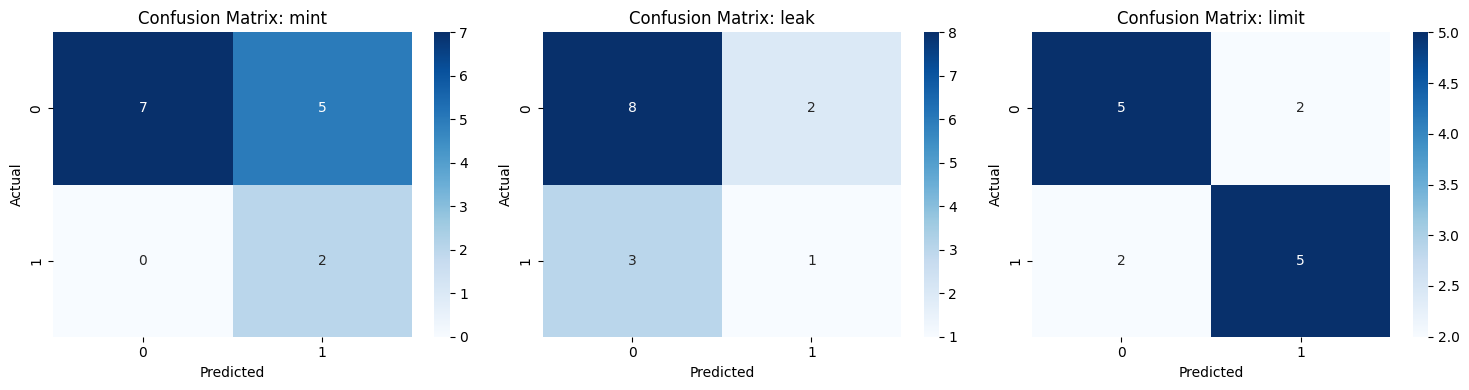

In [16]:
best_model = models[df_report['Model'][0]]
y_pred = best_model.predict(X_test)

display_multilabel_confusion_matrix(y_test, y_pred)

In [17]:
labels = y.columns.tolist()  # assuming y is a pandas DataFrame

for i, label in enumerate(labels):
    report_dict = classification_report(y_test[label], y_pred[:, i], output_dict=True)
    f1 = report_dict["macro avg"]["f1-score"]
    print(f"{label}, f1-score: {f1}")

mint, f1-score: 0.5906432748538011
leak, f1-score: 0.5238095238095237
limit, f1-score: 0.7142857142857143


In [18]:
df_report = get_report_all_ml(grouping_X_train, grouping_y_train, grouping_X_test, grouping_y_test)
df_report

[LightGBM] [Info] Number of positive: 17, number of negative: 36
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 601
[LightGBM] [Info] Number of data points in the train set: 53, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.320755 -> initscore=-0.750306
[LightGBM] [Info] Start training from score -0.750306
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[L

,Model,Precision,Recall,F1-score
0,OneVsRestClassifier(KNeighborsClassifier()),0.515873,0.654762,0.515873
1,MultiOutputClassifier(KNeighborsClassifier()),0.515873,0.654762,0.515873
2,OneVsRestClassifier(SGDClassifier()),0.332418,0.952381,0.481481
3,MultiOutputClassifier(GaussianNB()),0.422619,0.571429,0.462963
4,OneVsRestClassifier(GaussianNB()),0.422619,0.571429,0.462963
5,MultiOutputClassifier(AdaBoostClassifier()),0.400000,0.523810,0.412698
6,OneVsRestClassifier(ExtraTreesClassifier()),0.400000,0.523810,0.412698
7,OneVsRestClassifier(AdaBoostClassifier()),0.400000,0.523810,0.412698
8,OneVsRestClassifier(DecisionTreeClassifier()),0.349206,0.571429,0.404762
9,MultiOutputClassifier(DecisionTreeClassifier()),0.373016,0.571429,0.404558


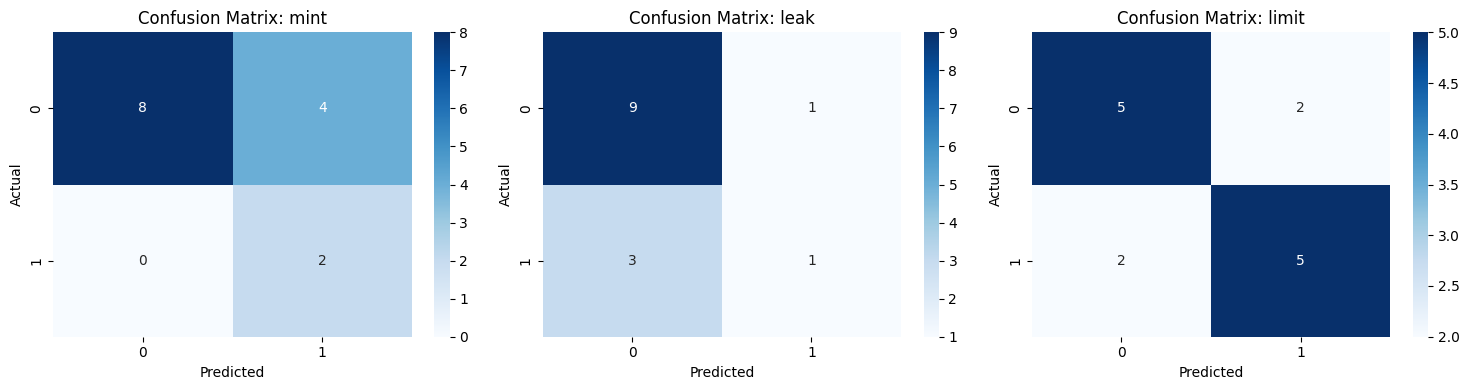

In [19]:
best_model = models[df_report['Model'][0]]
y_pred = best_model.predict(grouping_X_test)

display_multilabel_confusion_matrix(grouping_y_test, y_pred)

In [20]:
labels = y.columns.tolist()  # assuming y is a pandas DataFrame

for i, label in enumerate(labels):
    report_dict = classification_report(grouping_y_test[label], y_pred[:, i], output_dict=True)
    f1 = report_dict["macro avg"]["f1-score"]
    print(f"{label}, f1-score: {f1}")

mint, f1-score: 0.65
leak, f1-score: 0.5757575757575758
limit, f1-score: 0.7142857142857143


## MLP

### Build model

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import MeanSquaredError

2025-07-15 15:15:03.020803: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
def Model(input_dim, output_dim):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(512, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.4),

        Dense(256, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.3),

        Dense(128, kernel_regularizer=regularizers.l1_l2(1e-6)),
        BatchNormalization(),
        LeakyReLU(0.01),
        Dropout(0.2),

        Dense(output_dim, activation='sigmoid')  # sigmoid for multi-label
    ])

    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-6),
        metrics=['accuracy']
    )
    return model

In [23]:
model = Model(input_dim=X.shape[1], output_dim=y.shape[1])

In [24]:
grouping_model = Model(input_dim=grouping_X.shape[1], output_dim=y.shape[1])

### Train

In [25]:
model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 320ms/step - accuracy: 0.5789 - loss: 0.8187 - val_accuracy: 0.8182 - val_loss: 1.9668 - learning_rate: 1.0000e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.3894 - loss: 0.7609 - val_accuracy: 0.8182 - val_loss: 1.3369 - learning_rate: 1.0000e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3686 - loss: 0.8403 - val_accuracy: 0.8182 - val_loss: 1.1751 - learning_rate: 1.0000e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3209 - loss: 0.8902 - val_accuracy: 0.8182 - val_loss: 1.0806 - learning_rate: 1.0000e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3472 - loss: 0.8436 - val_accuracy: 0.7273 - val_loss: 0.9898 - learning_rate: 1.0000e-06
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.2579 - loss: 0.8891 - val_accuracy: 0.7273 - val_loss: 0.9354 - learning_rate: 1.0000e-06
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.3948 - loss

In [26]:
grouping_model.fit(grouping_X_train, grouping_y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )

Epoch 1/100


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 303ms/step - accuracy: 0.1895 - loss: 0.8673 - val_accuracy: 0.0000e+00 - val_loss: 2.4044 - learning_rate: 1.0000e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.1369 - loss: 0.8356 - val_accuracy: 0.0000e+00 - val_loss: 1.8832 - learning_rate: 1.0000e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2054 - loss: 0.8770 - val_accuracy: 0.0000e+00 - val_loss: 1.6863 - learning_rate: 1.0000e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2054 - loss: 0.8831 - val_accuracy: 0.0909 - val_loss: 1.5300 - learning_rate: 1.0000e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.1265 - loss: 0.9119 - val_accuracy: 0.0909 - val_loss: 1.4161 - learning_rate: 1.0000e-06
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2158 - loss: 0.9194 - val_accuracy: 0.0909 - val_loss: 1.3420 - learning_rate: 1.0000e-06
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.1632 - loss

### Predict

In [27]:
y_test_prob = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


In [28]:
def tune_thresholds(y_true, y_pred_prob, metric='f1'):
    y_true = np.asarray(y_true)          # Fix: convert to NumPy
    y_pred_prob = np.asarray(y_pred_prob)

    best_thresholds = []
    best_scores = []

    for i in range(y_true.shape[1]):
        label_true = y_true[:, i]
        label_probs = y_pred_prob[:, i]  # Fix here too

        thresholds = np.linspace(0.0, 1.0, 101)
        scores = []

        for t in thresholds:
            label_pred = (label_probs >= t).astype(int)
            if metric == 'f1':
                score = f1_score(label_true, label_pred, zero_division=0)
            scores.append(score)

        best_t = thresholds[np.argmax(scores)]
        best_score = np.max(scores)

        best_thresholds.append(best_t)
        best_scores.append(best_score)

        print(f"Label {i}: Best threshold = {best_t:.2f}, Best {metric} = {best_score:.4f}")

    return best_thresholds, best_scores


In [29]:
best_thresholds, _ = tune_thresholds(y_test, y_test_prob)

Label 0: Best threshold = 0.61, Best f1 = 0.3077
Label 1: Best threshold = 0.00, Best f1 = 0.4444
Label 2: Best threshold = 0.13, Best f1 = 0.7368


In [30]:
y_pred = (model.predict(X_test) >= best_thresholds).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [31]:
grouping_y_test_prob = grouping_model.predict(grouping_X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step


In [32]:
grouping_best_thresholds, _ = tune_thresholds(grouping_y_test, grouping_y_test_prob)

Label 0: Best threshold = 0.40, Best f1 = 0.2857
Label 1: Best threshold = 0.72, Best f1 = 0.5714
Label 2: Best threshold = 0.21, Best f1 = 0.7000


In [33]:
grouping_y_pred = (grouping_model.predict(grouping_X_test) >= grouping_best_thresholds).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


### Report

In [34]:
print(classification_report(y_test, y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.18      1.00      0.31         2
        leak       0.29      1.00      0.44         4
       limit       0.58      1.00      0.74         7

   micro avg       0.35      1.00      0.52        13
   macro avg       0.35      1.00      0.50        13
weighted avg       0.43      1.00      0.58        13
 samples avg       0.33      0.64      0.43        13



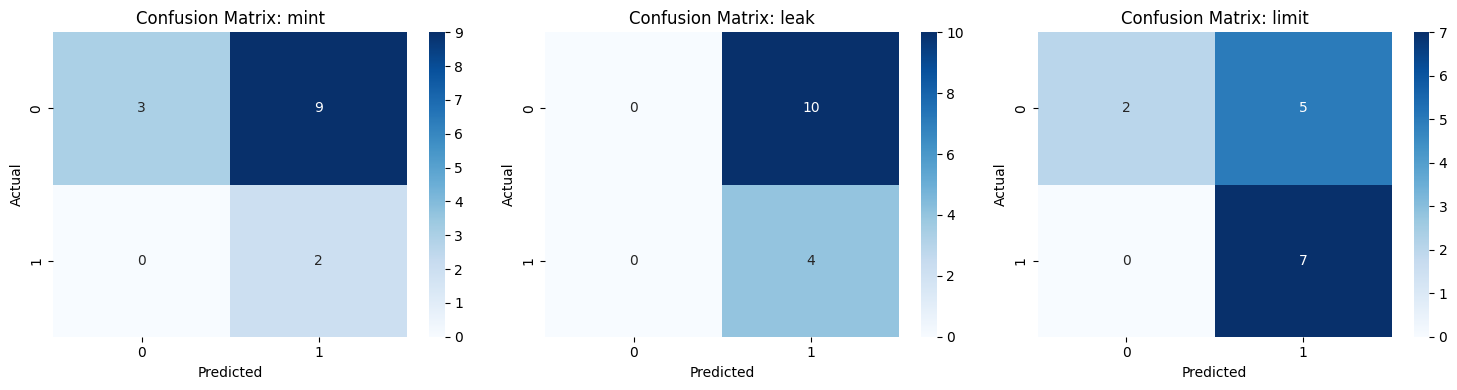

In [35]:
display_multilabel_confusion_matrix(y_test, y_pred)

In [36]:
print(classification_report(grouping_y_test, grouping_y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.17      1.00      0.29         2
        leak       0.67      0.50      0.57         4
       limit       0.54      1.00      0.70         7

   micro avg       0.39      0.85      0.54        13
   macro avg       0.46      0.83      0.52        13
weighted avg       0.52      0.85      0.60        13
 samples avg       0.36      0.54      0.41        13



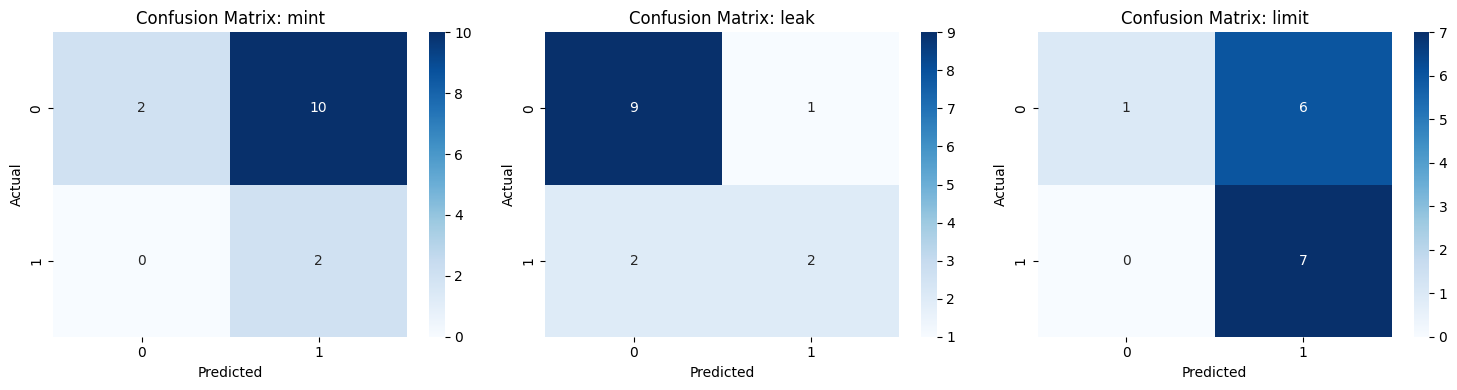

In [37]:
display_multilabel_confusion_matrix(grouping_y_test, grouping_y_pred)

## Autoencoder + MPL

In [38]:
def Autoencoder(input_dim=256):
    model = Sequential([
        Input(shape=(input_dim,)),
        Dense(128),
        LeakyReLU(0.01),

        Dense(32),
        BatchNormalization(),
        LeakyReLU(0.01),

        Dense(128),
        BatchNormalization(),
        LeakyReLU(0.01),

        Dense(input_dim, activation='sigmoid')  # sigmoid for multi-label
    ])

    model.compile(optimizer=Adam(1e-6), loss=MeanSquaredError())
    return model


In [39]:
autoencoder = Autoencoder(input_dim=X.shape[1])
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - loss: 8724.9443 - val_loss: 5996.2388
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 8857.1748 - val_loss: 5996.4014
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 8984.6631 - val_loss: 5996.5112
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 8460.6143 - val_loss: 5996.6582
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 9170.3887 - val_loss: 5996.7183
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 8950.0645 - val_loss: 5996.7739
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 8909.6660 - val_loss: 5996.8110
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 8640.2773 - val_loss: 5996.8716
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - loss: 8306.0781 - val_loss: 5996.9302
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 9105.4336 - val_loss: 5996.9771
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 8360.6592 - val_loss: 5997.0405
Epoch 12/50
2/2 ━━

In [40]:
grouping_autoencoder = Autoencoder(input_dim=grouping_X.shape[1])
grouping_autoencoder.fit(grouping_X_train, grouping_X_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 208ms/step - loss: 36936.6367 - val_loss: 24731.0938
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 36126.5156 - val_loss: 24733.8359
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 34949.5820 - val_loss: 24735.9453
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 36866.8711 - val_loss: 24737.1445
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 35805.5508 - val_loss: 24738.0547
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 36963.7148 - val_loss: 24738.5703
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 38301.4492 - val_loss: 24738.9355
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 35526.6133 - val_loss: 24739.3457
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 34076.0820 - val_loss: 24739.8438
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 36465.7852 - val_loss: 24740.1992
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 34791.1758 - val_loss: 24740.4

In [41]:
X_train_encoded = autoencoder.predict(X_train)
X_test_encoded = autoencoder.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


In [42]:
grouping_X_train_encoded = grouping_autoencoder.predict(grouping_X_train)
grouping_X_test_encoded = grouping_autoencoder.predict(grouping_X_test)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/stepWARNING:tensorflow:6 out of the last 9 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x133db28e0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [43]:
model = Model(input_dim=X_train_encoded.shape[1], output_dim=y.shape[1])

In [44]:
grouping_model = Model(input_dim=grouping_X_train_encoded.shape[1], output_dim=grouping_y.shape[1])

In [45]:
model.fit(X_train_encoded, y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )

Epoch 1/100


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - accuracy: 0.2842 - loss: 0.7921 - val_accuracy: 0.1818 - val_loss: 0.6490 - learning_rate: 1.0000e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3472 - loss: 0.7905 - val_accuracy: 0.1818 - val_loss: 0.6510 - learning_rate: 1.0000e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.3894 - loss: 0.7434 - val_accuracy: 0.1818 - val_loss: 0.6535 - learning_rate: 1.0000e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.3790 - loss: 0.7874 - val_accuracy: 0.1818 - val_loss: 0.6556 - learning_rate: 1.0000e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2842 - loss: 0.7406 - val_accuracy: 0.1818 - val_loss: 0.6575 - learning_rate: 1.0000e-06
Epoch 6/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3438 - loss: 0.7569
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999987376214e-07.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3209 - loss: 0.7256 - val_ac

In [46]:
grouping_model.fit(grouping_X_train_encoded, grouping_y_train, validation_split=0.2, epochs=100, batch_size=32,
                    callbacks=[
                                EarlyStopping(monitor='val_loss',
                                             patience=5,
                                             restore_best_weights=True),
                                ReduceLROnPlateau(
                                  monitor='val_loss',
                                  factor=0.5,
                                  patience=5,
                                  verbose=1)
                               ]
                    )

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 297ms/step - accuracy: 0.3631 - loss: 1.0420 - val_accuracy: 0.8182 - val_loss: 0.7193 - learning_rate: 1.0000e-06
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3105 - loss: 0.8826 - val_accuracy: 0.8182 - val_loss: 0.7178 - learning_rate: 1.0000e-06
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.3790 - loss: 0.9161 - val_accuracy: 0.8182 - val_loss: 0.7175 - learning_rate: 1.0000e-06
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.4315 - loss: 0.8323 - val_accuracy: 0.8182 - val_loss: 0.7164 - learning_rate: 1.0000e-06
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.3581 - loss: 0.9025 - val_accuracy: 0.8182 - val_loss: 0.7165 - learning_rate: 1.0000e-06
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.5159 - loss: 0.8691 - val_accuracy: 0.8182 - val_loss: 0.7164 - learning_rate: 1.0000e-06
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.4945 - loss

In [47]:
y_pred_prob = model.predict(X_test_encoded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step


In [48]:
grouping_y_pred_prob = grouping_model.predict(grouping_X_test_encoded)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step


In [49]:
best_thresholds, _ = tune_thresholds(y_test, y_test_prob)

Label 0: Best threshold = 0.61, Best f1 = 0.3077
Label 1: Best threshold = 0.00, Best f1 = 0.4444
Label 2: Best threshold = 0.13, Best f1 = 0.7368


In [50]:
grouping_best_thresholds, _ = tune_thresholds(grouping_y_test, grouping_y_test_prob)

Label 0: Best threshold = 0.40, Best f1 = 0.2857
Label 1: Best threshold = 0.72, Best f1 = 0.5714
Label 2: Best threshold = 0.21, Best f1 = 0.7000


In [51]:
y_pred = (model.predict(X_test) >= best_thresholds).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


In [52]:
grouping_y_pred = (grouping_model.predict(grouping_X_test) >= grouping_best_thresholds).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


### Report

In [53]:
print(classification_report(y_test, y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.00      0.00      0.00         2
        leak       0.29      1.00      0.44         4
       limit       0.50      1.00      0.67         7

   micro avg       0.39      0.85      0.54        13
   macro avg       0.26      0.67      0.37        13
weighted avg       0.36      0.85      0.50        13
 samples avg       0.39      0.57      0.45        13



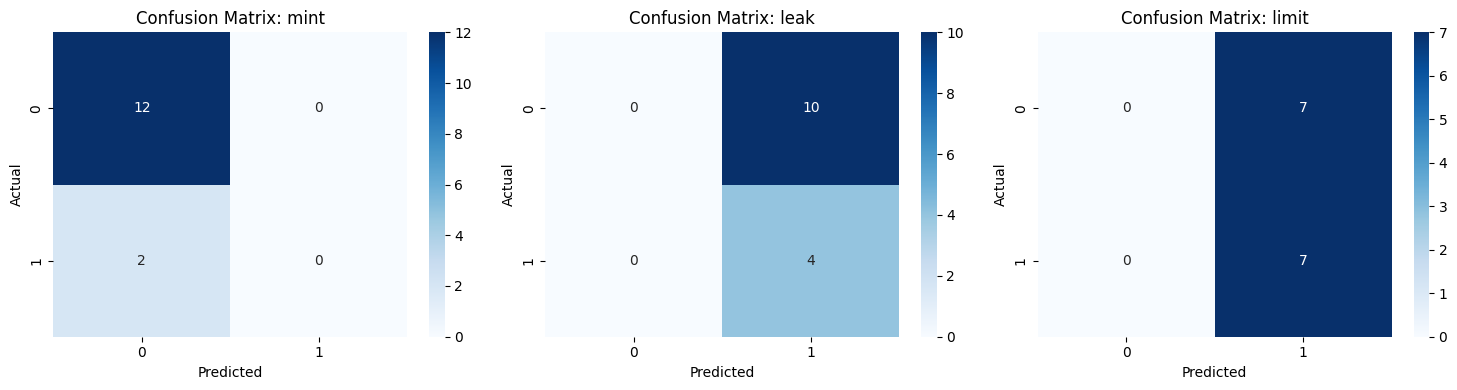

In [54]:
display_multilabel_confusion_matrix(y_test, y_pred)

In [55]:
print(classification_report(grouping_y_test, grouping_y_pred, target_names=y.columns))

              precision    recall  f1-score   support

        mint       0.14      1.00      0.25         2
        leak       0.29      1.00      0.44         4
       limit       0.44      0.57      0.50         7

   micro avg       0.27      0.77      0.40        13
   macro avg       0.29      0.86      0.40        13
weighted avg       0.35      0.77      0.44        13
 samples avg       0.24      0.43      0.30        13



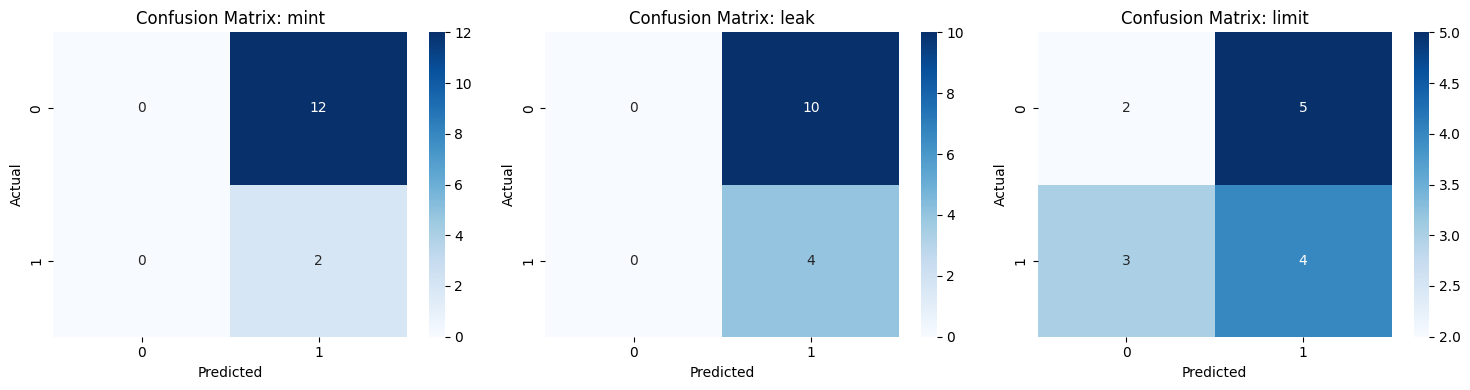

In [56]:
display_multilabel_confusion_matrix(grouping_y_test, grouping_y_pred)